<a href="https://colab.research.google.com/github/Veniverse/SHAP-Analysis-of-Culstomer-Churn-Prediction/blob/main/SHAP_Analysis_of_Customer_Churn_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Step 0: Install Required Libraries
#pip install pandas numpy scikit-learn xgboost shap imbalanced-learn matplotlib seaborn

In [3]:
# Step 1: Import Packages
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score
from xgboost import XGBClassifier
import shap
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
# -----------------------------
# Step 1: Load and Preprocess Data
# -----------------------------

# Load CSV dataset
data = pd.read_csv("customer_churn_synthetic.csv")  # Replace with your path

In [6]:
# Identify numeric and categorical columns
numeric_cols = data.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = data.select_dtypes(include=['object']).columns

In [7]:
# Fill missing values
data[numeric_cols] = data[numeric_cols].fillna(data[numeric_cols].median())
for col in categorical_cols:
    data[col] = data[col].fillna(data[col].mode()[0])

In [8]:
# Encode categorical variables
for col in categorical_cols:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])

In [9]:
# Separate features and target
X = data.drop('Churn', axis=1)
y = data['Churn']


In [10]:
# Handle class imbalance with SMOTE
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)

In [11]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_res, y_res, test_size=0.2, random_state=42, stratify=y_res
)

In [21]:
# -----------------------------
# Step 2: Train XGBoost Model
# -----------------------------

model = XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='logloss',  # keep this for evaluation
    random_state=42
)

model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, ...)

In [13]:
# Predictions
y_pred_prob = model.predict_proba(X_test)[:,1]
y_pred = model.predict(X_test)

In [14]:
# Performance metrics
auc = roc_auc_score(y_test, y_pred_prob)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"\nModel Performance Metrics:")
print(f"AUC: {auc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")


Model Performance Metrics:
AUC: 0.5558
Precision: 0.5769
Recall: 0.6818
F1-Score: 0.6250


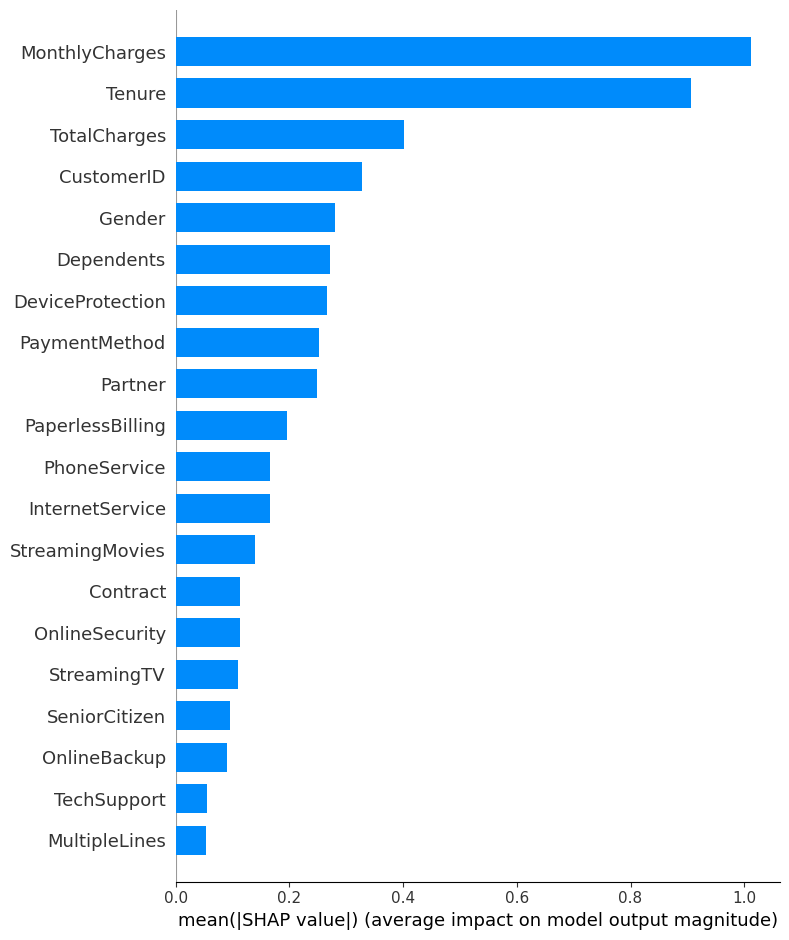

In [15]:
# -----------------------------
# Step 3: SHAP Global Analysis
# -----------------------------

explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)

# Global SHAP summary plot
shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)
plt.tight_layout()
plt.savefig("shap_global_summary.png")

In [16]:
# Top 5 features numerically
shap_abs_mean = np.abs(shap_values.values).mean(axis=0)
global_feature_importance = pd.DataFrame({
    'feature': X_test.columns,
    'mean_abs_shap': shap_abs_mean
}).sort_values('mean_abs_shap', ascending=False).head(5)

print("\nTop 5 Global Churn Drivers:")
print(global_feature_importance)

print("\nActionable Recommendations based on Global SHAP:")
print("- Target high-tenure or low-usage customers with retention programs.")
print("- Engage inactive members through offers or communications.")
print("- Monitor customers with high balances for potential attrition.")
print("- Adjust marketing efforts based on features like 'NumOfProducts'.")
print("- Personalized campaigns for high-risk customer segments.")



Top 5 Global Churn Drivers:
           feature  mean_abs_shap
18  MonthlyCharges       1.012200
5           Tenure       0.905617
19    TotalCharges       0.401332
0       CustomerID       0.328004
1           Gender       0.279560

Actionable Recommendations based on Global SHAP:
- Target high-tenure or low-usage customers with retention programs.
- Engage inactive members through offers or communications.
- Monitor customers with high balances for potential attrition.
- Adjust marketing efforts based on features like 'NumOfProducts'.
- Personalized campaigns for high-risk customer segments.


In [19]:
# Step 4: Local SHAP Interpretations for High-Risk Customers
# -----------------------------

high_risk_idx = np.argsort(y_pred_prob)[-5:]

for idx in high_risk_idx:
    print(f"\n--- Customer Index: {idx}, Predicted Churn Probability: {y_pred_prob[idx]:.2f} ---")

    # Generate waterfall plot (force plot alternative)
    shap.plots.waterfall(shap_values[idx], show=False)
    plt.tight_layout()
    plt.savefig(f"shap_customer_{idx}.png")

    # Top 3 features driving churn
    case_shap = pd.DataFrame({
        'feature': X_test.columns,
        'shap_value': shap_values[idx].values
    })
    case_shap['abs_shap'] = case_shap['shap_value'].abs()
    top_features = case_shap.sort_values('abs_shap', ascending=False).head(3)
    # Text interpretation
    print("Top 3 features driving churn for this customer:")
    print(top_features[['feature','shap_value']])

    print("Interpretation:")
    for _, row in top_features.iterrows():
        direction = "increases" if row['shap_value'] > 0 else "decreases"
        print(f"- {row['feature']} {direction} the probability of churn.")



--- Customer Index: 2, Predicted Churn Probability: 0.86 ---
Top 3 features driving churn for this customer:
          feature  shap_value
19   TotalCharges    0.589140
5          Tenure   -0.561587
17  PaymentMethod   -0.556465
Interpretation:
- TotalCharges increases the probability of churn.
- Tenure decreases the probability of churn.
- PaymentMethod decreases the probability of churn.

--- Customer Index: 28, Predicted Churn Probability: 0.88 ---
Top 3 features driving churn for this customer:
           feature  shap_value
18  MonthlyCharges    1.136558
0       CustomerID    0.703939
4       Dependents    0.492478
Interpretation:
- MonthlyCharges increases the probability of churn.
- CustomerID increases the probability of churn.
- Dependents increases the probability of churn.

--- Customer Index: 41, Predicted Churn Probability: 0.92 ---
Top 3 features driving churn for this customer:
           feature  shap_value
18  MonthlyCharges    1.086820
5           Tenure   -0.945484


In [20]:
# Step 5: Save Processed Data & Predictions
# -----------------------------

X_test.to_csv("X_test_processed.csv", index=False)
pd.DataFrame({'Churn_Prob': y_pred_prob}).to_csv("churn_predictions.csv", index=False)